In [1]:
## load PFCLM output and compare to Ameriflux data

import parflow as pf
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from glob import glob
import pandas as pd
import parflow as pf
from pathlib import Path

from parflow import Run
import parflow.tools.hydrology as hydro


import hf_hydrodata as hf

# swap to your email and PIN
## [register PIN here](https://hydrogen.princeton.edu/pin)
#hf.gridded.register_api_pin("<your_email>", "<your_pin>")
from set_demo_defaults import *

In [2]:

# provide a start and end date for the data; this will also provide the start and end dates for your PF-CLM run
# the start date should be the first day of the water year you want to run, and the end date should be the last day of the water year
start = "2010-01-01"
end = "2023-01-01"
static_write_dir = "/home/ms6985/ParFlow-project/Colliander_US-Ha1"
base = static_write_dir 
#choose a site from the Ameriflux network
site_id = 'US-Ha1'

print('working directory: ', base)

# get info and metadata for the Ameriflux site we are interested in comparing to
data_set = "ameriflux"
variable = 'latent_heat'
temporal_resolution = 'hourly'
aggregation = 'sum'

metadata_df = hf.get_point_metadata(dataset =  data_set, variable =variable, temporal_resolution =  temporal_resolution, aggregation =aggregation,site_ids=site_id)
metadata_df.head(5)


working directory:  /home/ms6985/ParFlow-project/Colliander_US-Ha1


,site_id,site_name,site_type,agency,state,latitude,longitude,first_date_data_available,last_date_data_available,record_count,...,ameriflux_mean_annual_precip,ameriflux_team_member_name,ameriflux_team_member_role,ameriflux_team_member_email,ameriflux_team_member_institution,ameriflux_site_funding,ameriflux_acknowledgement,ameriflux_acknowledgement_comment,ameriflux_doi_citation,ameriflux_alternate_url
0,US-Ha1,Harvard Forest EMS Tower (HFR1),flux tower,AmeriFlux,MA,42.5378,-72.1715,1991-01-01,2022-06-29,276048,...,1071.0,"J. William Munger, Jaclyn Matthes","PI, Affiliate","jwmunger@seas.harvard.edu, jaclyn_matthes@fas....",Harvard University,"DOE/TES (AmeriFlux Core site), NSF/LTER",Operation of the US-Ha1 site is supported by t...,None,"J. William Munger (2022), AmeriFlux BASE US-Ha...",http://atmos.seas.harvard.edu/lab/hf/index.html


In [3]:
import os
path = ''
current_dir = os.getcwd()
print(current_dir)
relative_path_to_runfolder = 'output_water_balance'
path = current_dir+'/'+relative_path_to_runfolder
print(path)

base = current_dir+'/'+relative_path_to_runfolder

#path_forcing = current_dir+'/forcing'
#print(path_forcing)


# load in the run information from the PFIDB file
run_name = 'pfclm_sc'
run = Run.from_definition(f'{base}/{run_name}.pfidb')
data = run.data_accessor
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz


# intialize data and time arrays
data    = np.zeros([8,113952])
time    = np.zeros([113952])

#CLM data array format 
# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0 eflx_lh_tot:  total latent heat flux (Wm-2)  
# 1 eflx_lwrad_out: total upward LW radiation (Wm-2)  
# 2 eflx_sh_tot: total sensible heat flux (Wm-2)  
# 3 eflx_soil_grnd: ground heat flux (Wm-2)    
# 4 qflx_evap_tot: net veg. evaporation and transpiration and soil evaporation (mms-1)  
# 5 qflx_evap_grnd: ground evaporation (mms-1)   
# 6 qflx_evap_soi: soil evaporation (mms-1)   
# 7 qflx_evap_veg: vegetation evaporation (canopy) and transpiration (mms-1)   
# 8 qflx_tran_veg: transpiration (mms-1)  
# 9 qflx_infl: infiltration flux (mms-1)   
# 10 swe_out: SWE (mm)   
# 11 t_grnd: ground temperature (K)  
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)

file_in = base+"/pfclm_sc.out.00000.nc"
print(file_in)
pf_out = xr.open_mfdataset(file_in)
print(pf_out.head())

file_in = base+"/pfclm_sc.out.CLM.00001.nc"
print(file_in)
clm_out = xr.open_mfdataset(file_in)
print(clm_out.head())


/home/ms6985/ParFlow-project/Colliander_US-Ha1
/home/ms6985/ParFlow-project/Colliander_US-Ha1/output_water_balance
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
/home/ms6985/ParFlow-project/Colliander_US-Ha1/output_water_balance/pfclm_sc.out.00000.nc
<xarray.Dataset>
Dimensions:     (time: 1, z: 5, y: 1, x: 1)
Coordinates:
  * time        (time) float64 0.0
Dimensions without coordinates: z, y, x
Data variables:
    pressure    (time, z, y, x) float64 dask.array<chunksize=(1, 5, 1, 1), meta=np.ndarray>
    saturation  (time, z, y, x) float64 dask.array<chunksize=(1, 5, 1, 1), meta=np.ndarray>
/home/ms6985/ParFlow-project/Colliander_US-Ha1/output_water_balance/pfclm_sc.out.CLM.00001.nc
<xarray.Dataset>
Dimensions:         (time: 5, y: 1, x: 1, z: 3)
Coordinates:
  * time            (time) float64 1.0 2.0 3.0 4.0 5.0
Dimensions without coordinates: y, x, z
Data variables: (12/13)
    eflx_lh_tot     (time, y, x) float64 dask.array<chunksize=(5, 1, 1), meta=np.

In [4]:

# load the forcing file into a Pandas dataframe

# load forcing, single column, variables are
#DSWR:  Downward Visible or Short-Wave radiation [W/m2]
#DLWR:  Downward Infa-Red or Long-Wave radiation [W/m2]
#APCP:  Precipitation rate [mm/s]
#Temp:  Air temperature [K]
#UGRD:  West-to-East or U-component of wind [m/s]
#VGRD:  South-to-North or V-component of wind [m/s]
#Press: Atmospheric Pressure [pa]
#SPFH:  Water-vapor specific humidity [kg/kg]

# load the forcing file into a Pandas dataframe
# we could load this file directly, as is shown in the commented-out line, but we can also
# use the key database and load it dynamically as shown

file = base+'/'+run.Solver.CLM.MetFileName
print(file)

# 1D forcing files are text columns not technically CSVs but this is an easy 
# way to load
forcing_df = pd.read_csv(file,sep=' ',header=None,engine='python') 
# add PF-CLM variable names and units 
forcing_df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]
print(forcing_df.head())



/home/ms6985/ParFlow-project/Colliander_US-Ha1/output_water_balance/forcing1D.US-Ha1.2010-01-01-2023-01-01.txt
   DSWR [W/m2]  DLWR [W/m2]  APCP [mm/s]    Temp [K]  UGRD [m/s]  VGRD [m/s]  \
0          0.0   288.416931          0.0  268.896301   -0.755066    1.266330   
1          0.0   288.416168          0.0  268.903076   -0.784911    0.728693   
2          0.0   288.664307          0.0  268.911743   -0.807767    0.198895   
3          0.0   289.161316          0.0  268.921295   -0.837613   -0.337658   
4          0.0   289.156860          0.0  268.842590   -0.468228   -0.510553   

     Press [pa]  SPFH [kg/kg]  
0  97466.359375      0.002763  
1  97414.351562      0.002746  
2  97362.460938      0.002730  
3  97310.500000      0.002714  
4  97242.757812      0.002706  


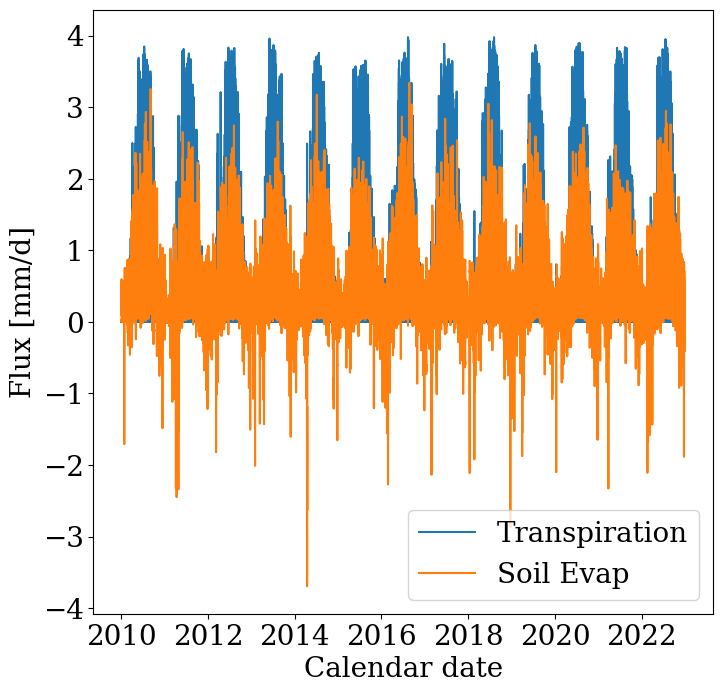

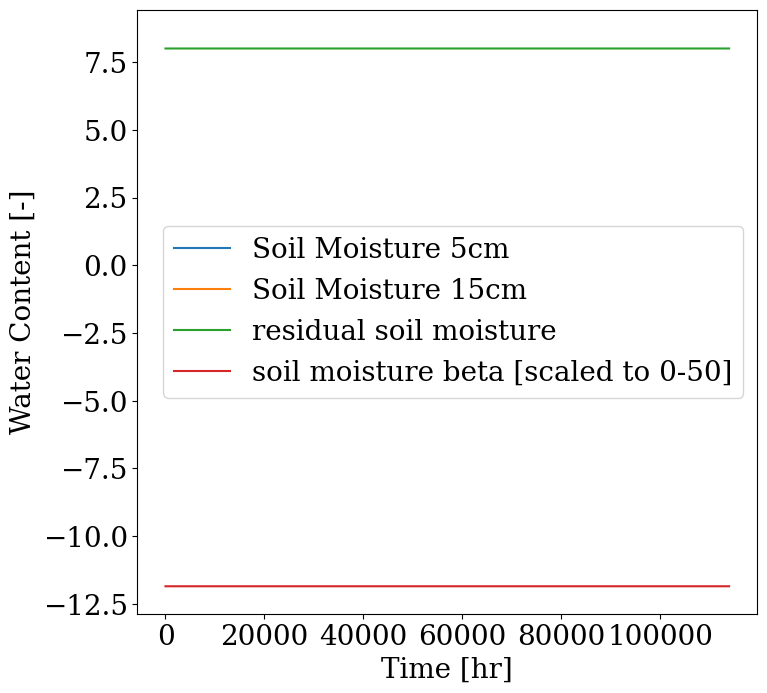

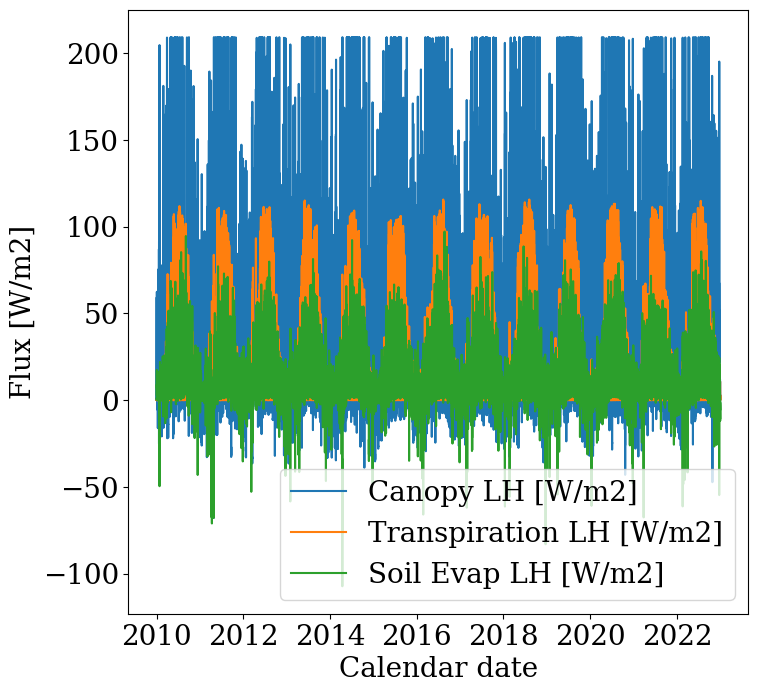

In [5]:
## make a plot of the output from the PFCLM run

res_sat = np.zeros(113952)
res_sat[:] = run.Solver.CLM.ResSat
porosity = run.Geom.domain.Porosity.Value

hvap   = 2.5104e06 #Latent heat of evap for water [J/kg]

# Define the format
from datetime import datetime, timedelta
date_format = "%Y-%m-%d"

t = np.arange(datetime.strptime(start, date_format), datetime.strptime(end, date_format), timedelta(hours=1)).astype(datetime)


# Plot the transpiration and soil evaporation for our PFCLM run
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,clm_out['qflx_tran_veg'][:,0,0]*(3600*24), label='Transpiration')
plt.plot(t,clm_out['qflx_evap_soi'][:,0,0]*(3600*24), label='Soil Evap')
plt.xlabel('Calendar date')  
plt.ylabel('Flux [mm/d]')  ## note that we converted the fluxes to mm/d
plt.legend()
plt.savefig(f'flux_evolution.pdf',bbox_inches='tight', dpi = 600)

# Plot the soil moisture for our PFCLM run
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(pf_out['saturation'][:,9,0,0]*100*porosity, label='Soil Moisture 5cm') 
plt.plot(pf_out['saturation'][:,8,0,0]*100*porosity, label='Soil Moisture 15cm') 
plt.plot(res_sat*100*porosity, label='residual soil moisture')
beta = (pf_out['saturation'][:,8,0,0]*50*porosity-res_sat*100*porosity)/(porosity*100-res_sat*100*porosity)
plt.plot(beta*100, label='soil moisture beta [scaled to 0-50]')
plt.xlabel('Time [hr]')  
plt.ylabel('Water Content [-]')  
plt.legend()
plt.savefig(f'soil_moisture_evolution.pdf',bbox_inches='tight', dpi = 600)

# convert the Transipration and Soil Evaporation to W/m2
# note that we are using the latent heat of vaporization for water
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,clm_out['qflx_evap_veg'][:,0,0]*hvap, label='Canopy LH [W/m2]')
plt.plot(t,clm_out['qflx_tran_veg'][:,0,0]*hvap, label='Transpiration LH [W/m2]')
plt.plot(t,clm_out['qflx_evap_soi'][:,0,0]*hvap, label='Soil Evap LH [W/m2]')
plt.xlabel('Calendar date') 
plt.ylabel('Flux [W/m2]')  ## note that we converted to energy fluxes
plt.legend()
plt.savefig(f'ET_fluxes.pdf',bbox_inches='tight', dpi = 600)

In [6]:
# Get data for our Ameriflux site
data_df = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,
                  date_end=end, site_ids=site_id)

data_df.head(5)

collecting data...
data collected.


,date,US-Ha1
0,2010-01-01 00:00:00,0.0
1,2010-01-01 01:00:00,0.0
2,2010-01-01 02:00:00,0.0
3,2010-01-01 03:00:00,0.0
4,2010-01-01 04:00:00,0.0


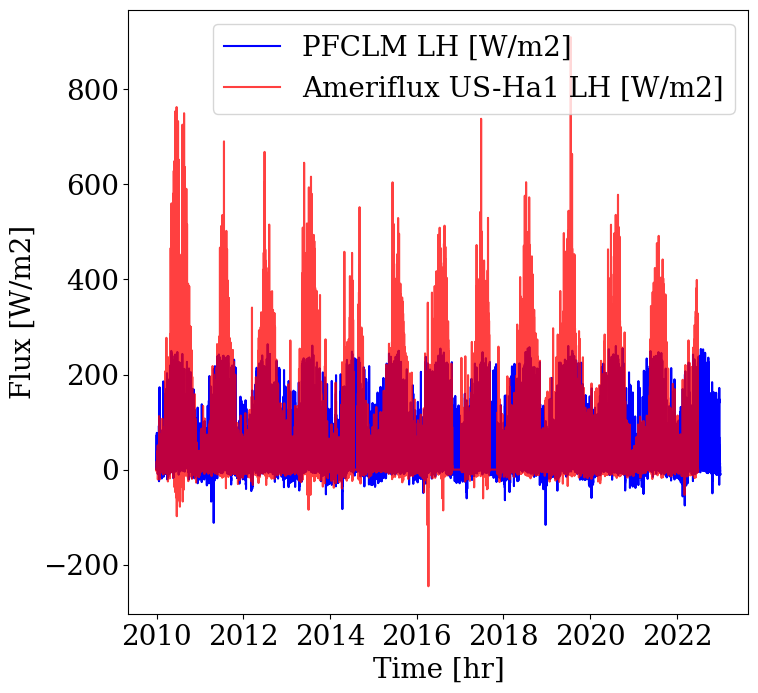

In [7]:
# Define the format
from datetime import datetime, timedelta
date_format = "%Y-%m-%d"

t = np.arange(datetime.strptime(start, date_format), datetime.strptime(end, date_format), timedelta(hours=1)).astype(datetime)

# Plot LH flux our Ameriflux site and our PFCLM run
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,clm_out['eflx_lh_tot'][:,0,0], label='PFCLM LH [W/m2]',color='blue') 
plt.plot(t[0:len(data_df[site_id])],data_df[site_id], label='Ameriflux '+site_id+' LH [W/m2]',alpha=0.75,color='red') 
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [W/m2]')  
plt.legend()
plt.savefig(f'latent_heat_flux_comparison.pdf',bbox_inches='tight', dpi = 600)

In [8]:
## now we can do some error checking, for example we can pull the solar radiation from the forcing file and compare it to the Ameriflux data

# Get data for our Ameriflux site
# get info and metadata for the Ameriflux site we are interested in comparing to
data_set = "ameriflux"
variable = 'downward_shortwave'
temporal_resolution = 'hourly'
aggregation = 'mean'


Ameriflux_DSW = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,date_end=end, site_ids=site_id)

Ameriflux_DSW.head(5)


ValueError: There are zero sites that satisfy the given parameters.

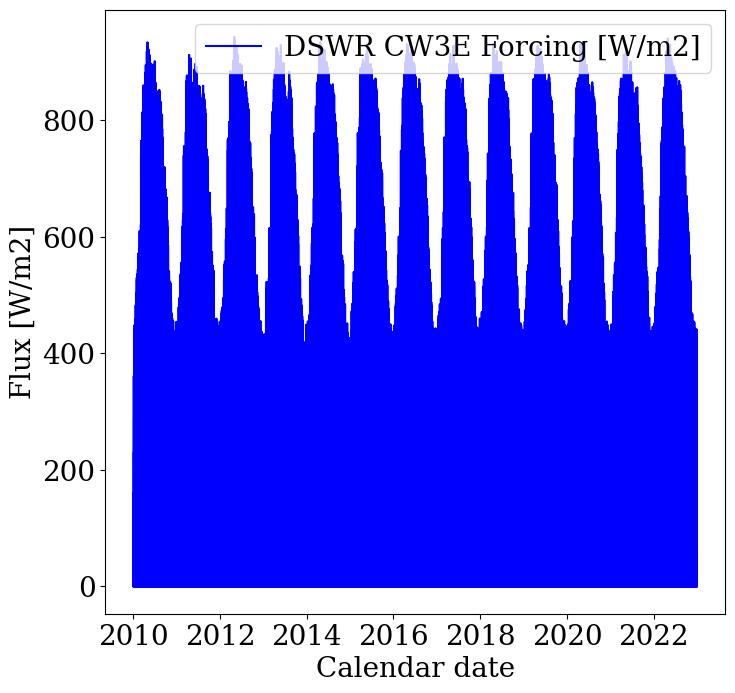

In [9]:
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,forcing_df["DSWR [W/m2]"], label='DSWR CW3E Forcing [W/m2]',color='blue')
#plt.plot(Ameriflux_DSW[site_id], label='Ameriflux '+site_id+' LH [W/m2]',alpha=0.75,color='red')
plt.xlabel('Calendar date')
plt.ylabel('Flux [W/m2]')
plt.legend()
plt.savefig(f'DSWR_CW3E_forcing.pdf',bbox_inches='tight', dpi = 600)

In [10]:
## now we can check Downward Longwave radiation
variable = 'downward_longwave'
Ameriflux_DLW = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,
                  date_end=end, site_ids=site_id)

Ameriflux_DLW.head(5)


ValueError: There are zero sites that satisfy the given parameters.

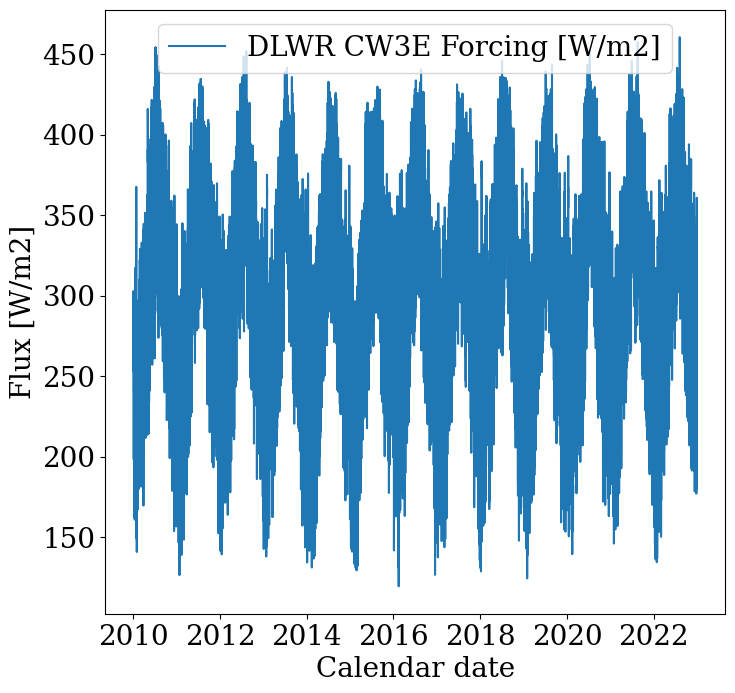

In [14]:
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,forcing_df["DLWR [W/m2]"], label='DLWR CW3E Forcing [W/m2]')
#plt.plot(t,Ameriflux_DLW[site_id], label='Ameriflux '+site_id+' LH [W/m2]')
plt.xlabel('Calendar date')
plt.ylabel('Flux [W/m2]')
plt.legend()
plt.savefig(f'DLWR_forcing.pdf',bbox_inches='tight', dpi = 600)

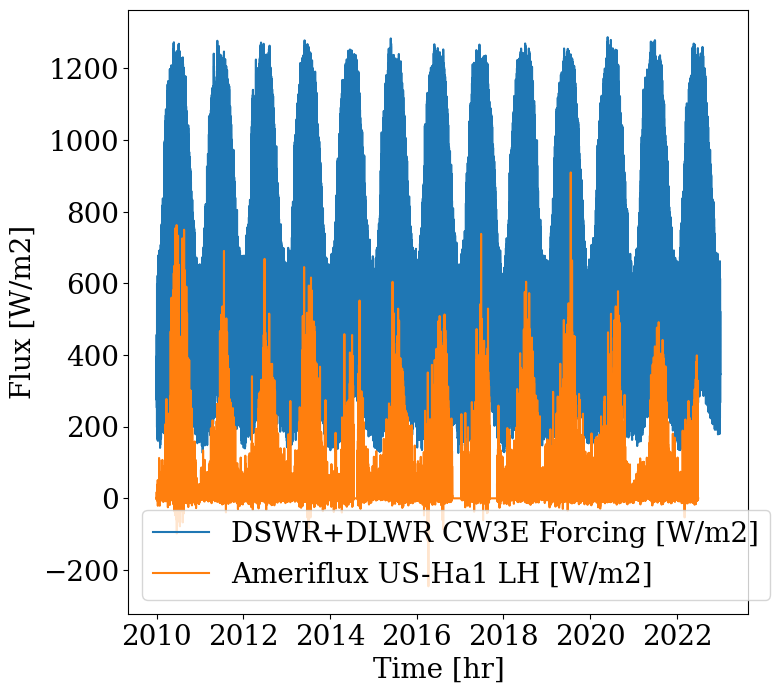

In [15]:
## now we can plot the combined radiation (downward shortwave + downward longwave) and compare to the Ameriflux LH observations
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,forcing_df["DLWR [W/m2]"]+forcing_df["DSWR [W/m2]"], label='DSWR+DLWR CW3E Forcing [W/m2]')
#plt.plot(Ameriflux_DLW[site_id]+Ameriflux_DSW[site_id], label='Ameriflux '+site_id+' DSWR+DLWR [W/m2]')
plt.plot(t[0:len(data_df[site_id])],data_df[site_id], label='Ameriflux '+site_id+' LH [W/m2]') 
plt.xlabel('Calendar date')
plt.xlabel('Time [hr]')
plt.ylabel('Flux [W/m2]')
plt.legend()
plt.savefig(f'DSWRplusDLWR_forcing.pdf',bbox_inches='tight', dpi = 600)


collecting data...
data collected.


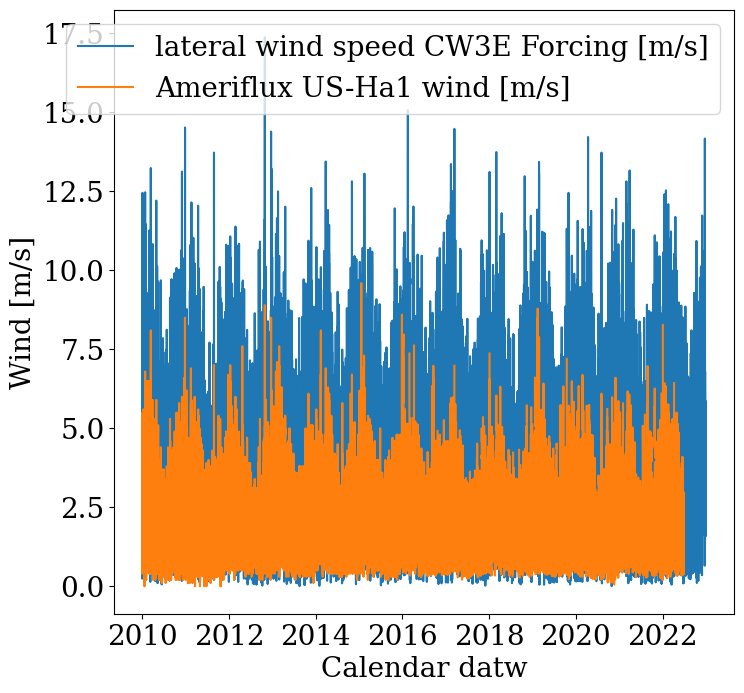

In [11]:

## now we can check the wind speed at the Ameriflux site and compare it to the forcing file
variable = 'wind_speed'
Ameriflux_wind = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  date_start=start,
                  date_end=end, site_ids=site_id)

Ameriflux_wind.head(5)

t = np.arange(datetime(2010,1,1), datetime(2023,1,1), timedelta(hours=1)).astype(datetime)


## now we can plot the combined radiation (downward shortwave + downward longwave) and compare to the Ameriflux LH observations
wind = np.sqrt(forcing_df["UGRD [m/s]"]**2+forcing_df["VGRD [m/s]"]**2)

fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t[0:len(wind)],wind, label='lateral wind speed CW3E Forcing [m/s]')
plt.plot(t[0:len(Ameriflux_wind[site_id])],Ameriflux_wind[site_id], label='Ameriflux '+site_id+' wind [m/s]')
plt.xlabel('Calendar datw')
plt.ylabel('Wind [m/s]')
plt.legend()
plt.savefig(f'wind_speed_evolution.pdf',bbox_inches='tight', dpi = 600)

In [12]:
from datetime import datetime, timedelta
# Input string
date_string = start
# Define the format
date_format = "%Y-%m-%d"

t = np.arange(datetime.strptime(start, date_format), datetime.strptime(end, date_format), timedelta(hours=1)).astype(datetime)


# Convert to datetime object
date_object = datetime.strptime(date_string, date_format)
new_date_object = np.empty_like(time_array)

for i in time_array[0:2]:
    new_date_object[i.astype(np.int64)] = date_object + timedelta(hours=i)
    print(f"Added {hours} hours: {new_date_object}")


t = np.arange(datetime(2010,1,1), datetime(2023,1,1), timedelta(hours=1)).astype(datetime)


NameError: name 'time_array' is not defined

/home/ms6985/ParFlow-project/Colliander_US-Ha1
/home/ms6985/ParFlow-project/Colliander_US-Ha1/output_water_balance/pfclm_sc
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


<ipython-input-23-cafe0049e5c5>:107: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(time_array_plot,z_array,data_array[:,:-1],400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')


  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


<ipython-input-23-cafe0049e5c5>:109: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  im = plt.contourf(time_array_plot,z_array,data_array[:,:-1],400, cmap='Blues',antialiased=False,edgecolor='face')


NameError: name 'clm_output' is not defined

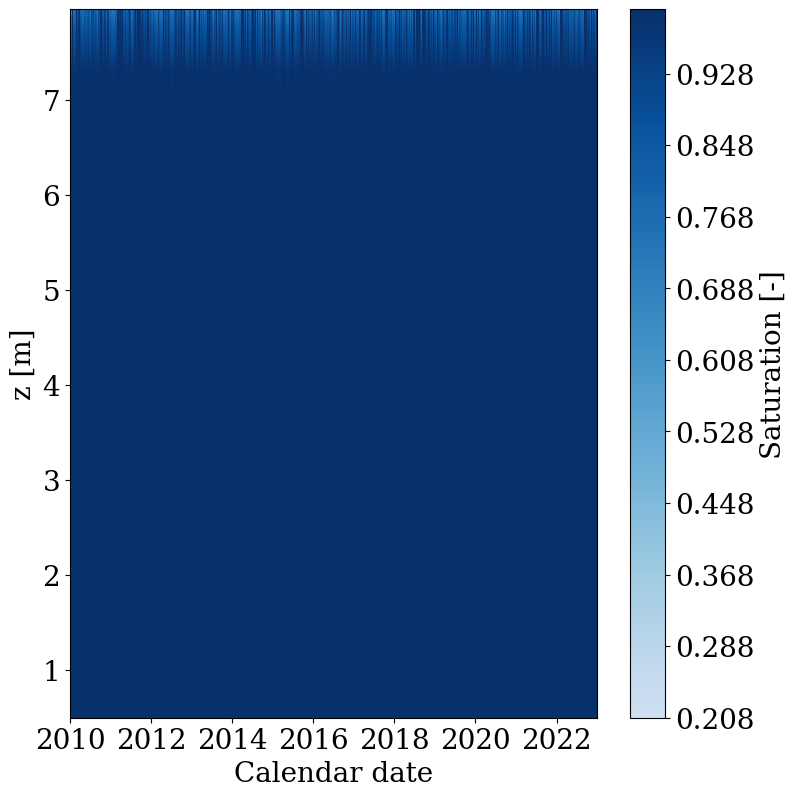

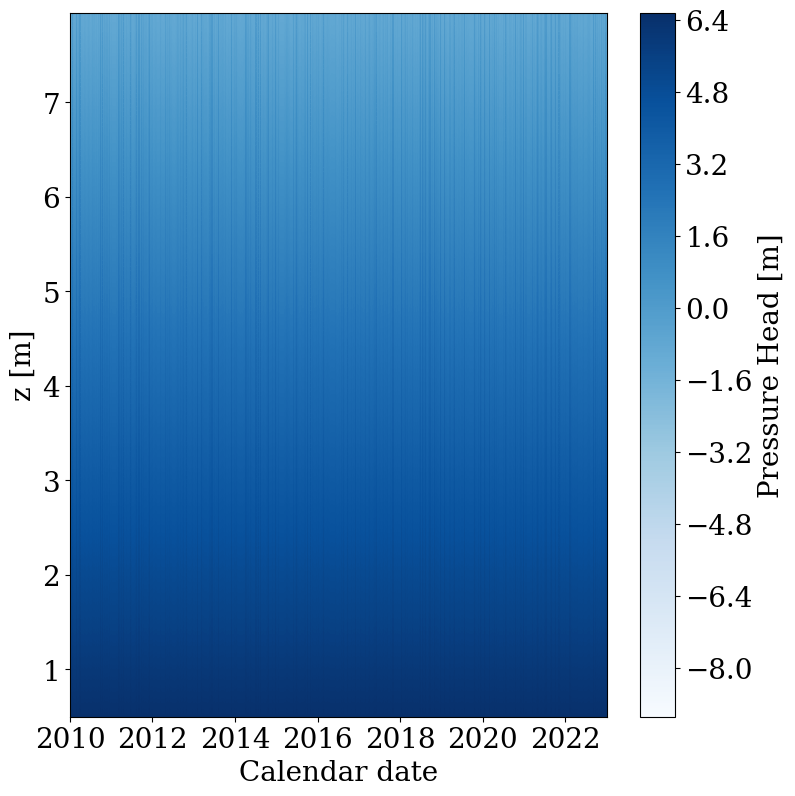

<Figure size 800x800 with 0 Axes>

In [23]:
import os
import shutil
from parflow.tools.fs import mkdir, cp, chdir, get_absolute_path, rm, exists
from parflow import Run
import parflow.tools.hydrology as hydro
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
import numpy as np
import matplotlib.pyplot as plt 

path = ''
current_dir = os.getcwd()
print(current_dir)
relative_path_to_runfolder = 'output_water_balance'
path = current_dir+'/'+relative_path_to_runfolder
run_name = 'pfclm_sc'
base = f'{path}/{run_name}'
print(base)
def plot_vert_var(base,variable, time_array,alpha_=2):
    """Function to plot output from a ParFlow run"""

    # Load the run from the file, this is the same as the run defined above
    run = Run.from_definition(f'{base}.pfidb')  

    data = run.data_accessor # get the data accessor, this makes it easier to access the data from the run
    nt = len(data.times)  # get the number of time steps
    nx = data.shape[2]    # get the number of cells in the x direction
    ny = data.shape[1]    # get the number of cells in the y direction
    nz = data.shape[0]    # get the number of cells in the z direction
    dx = data.dx          # get the cell size in the x direction
    dy = data.dy          # get the cell size in the y direction
    dz = data.dz          # get the cell size in the z direction, this is a 1D array of size nz

    # Print a summary of the run data
    #print(f"nx = {nx}, ny = {ny}, nz = {nz}, nt = {nt}")
    #print(f"dx = {dx}, dy = {dy}, dz = {dz[0]}")

    

    for timestep in time_array:
        # Load the data
        if variable == "porosity":
            data = read_pfb(get_absolute_path(f"pfclm_sc.out.{variable}.pfb")).reshape(nz, nx)
        elif variable == "mannings":
            data = read_pfb(get_absolute_path(f"pfclm_sc.out.mannings.pfb"))[0, :, :]
        else:
            data = read_pfb(get_absolute_path(f"pfclm_sc.out.{variable}.{str(timestep).zfill(5)}.pfb")).reshape(nz, nx)
        
        # Set negative saturation values to NaN
        if variable == "satur":
            data[data < 0.0] = np.nan
        
        # Set up x and z to match the shape of the ParFlow grid
        x = np.arange(0.0,(nx+1)*dx,dx)
        y = np.arange(0.0,(ny+1)*dy,dy)
        z = np.zeros(nz+1)
        z[1:] = np.cumsum(dz)

        #print(f"x = {x}, y = {y}, z = {z}")
        #print(f"Shapes of : x = {x.shape}, y = {y.shape}, z = {z.shape}")

        # Get limits for plotting
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        #print(f"vmin: {vmin}, vmax: {vmax}")
        
        # Define labels for plots
        if variable == "satur":
            label = "Saturation [-]"
            title = "Saturation [-]"
        elif variable == "press":
            label = "Pressure Head [m]"
            title = "Pressure Head [m]"
        elif variable == "porosity":
            label = "Porosity"
            title = "Porosity"
        elif variable == "mannings":
            label = "Mannings"
            title = "Mannings"

        #print(data.shape)

        if timestep ==0:
            data_array = data
        else:
            data_array = np.concatenate((data_array,data),axis=1 )

    z_mid = np.transpose(np.array([z[1:]-dz/2]))
    time_array_new = np.arange(datetime(2010,1,1), datetime(2023,1,1), timedelta(hours=1)).astype(datetime)
    #z_array = np.kron(np.ones(len(time_array)),z_mid)
    #time_array_plot = np.kron(np.ones(z_mid.shape),np.array([time_array]))
    #time_array_plot = np.kron(np.array([time_array_new]),np.array([time_array_new]))
    #time_array_plot = np.repeat(np.array([time_array_new]), z_mid.shape, axis=0)

    time_array_plot,z_array = np.meshgrid(time_array_new,z_mid)
    

    #print('Size: z',z.shape, 'time_array', time_array)
    #print('Size: z_array-',z_array.shape,'time_array', time_array_plot.shape,'data_array', data_array.shape)
    # Use pcolormesh to plot the data with the x and z coordinates with lines 
    # for the grid mesh from the ParFlow run grid

    #im = ax.pcolormesh(x, y, data, vmin=vmin, vmax=vmax, cmap='plasma_r')
    fig = plt.figure(figsize=(8,8) , dpi=100)
    #im = plt.plot(data,z[1:]-dz/2)#Plotting at cell centers
    if variable == "satur":
        im = plt.contourf(time_array_plot,z_array,data_array[:,:-1],400, cmap='Blues',vmin=0,vmax=1.0,antialiased=False,edgecolor='face')
    else:
        im = plt.contourf(time_array_plot,z_array,data_array[:,:-1],400, cmap='Blues',antialiased=False,edgecolor='face')        
    plt.xlabel(f"time [hours]")
    cbar = fig.colorbar(im)    
    cbar.ax.set_ylabel(f"{title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.xlabel('Calendar date')
    
    np.savez(f'{variable}_output',time_array_plot,z_array,data_array)
    plt.savefig(f'{variable}_output.pdf',bbox_inches='tight', dpi = 600)

plot_vert_var(base, "satur", np.linspace(0,len(clm_out['eflx_lh_tot'][:,0,0]),len(clm_out['eflx_lh_tot'][:,0,0])+1).astype('int'))
plot_vert_var(base, "press", np.linspace(0,len(clm_out['eflx_lh_tot'][:,0,0]),len(clm_out['eflx_lh_tot'][:,0,0])+1).astype('int'))



## make a plot of the output from the PFCLM run

res_sat = np.zeros(len(clm_out['eflx_lh_tot'][:,0,0]))
res_sat[:] = run.Solver.CLM.ResSat
porosity = run.Geom.domain.Porosity.Value

hvap   = 2.5104e06 #Latent heat of evap for water [J/kg]

# Plot the transpiration and soil evaporation for our PFCLM run
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(clm_output['T [mm/s]']*(3600*24), label='Transpiration', color=blue)  
plt.plot(clm_output['Ebs [mm/s]']*(3600*24), label='Soil Evap', color=red)  
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [mm/d]')  ## note that we converted the fluxes to mm/d
plt.savefig(f'output.pdf',bbox_inches='tight', dpi = 600)


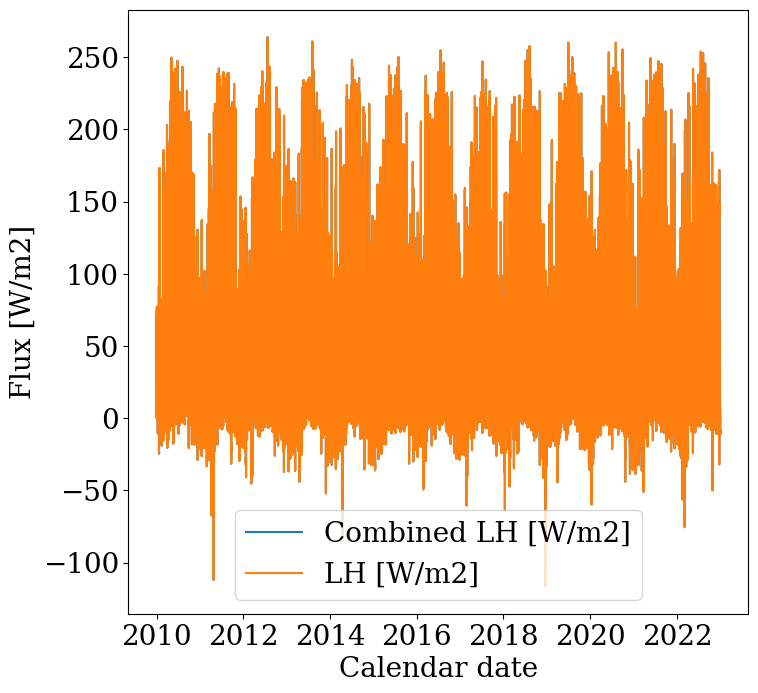

In [13]:
# convert the Transipration and Soil Evaporation to W/m2
# note that we are using the latent heat of vaporization for water
fig = plt.figure(figsize=(8,8) , dpi=100)
plt.plot(t,clm_out['qflx_evap_veg'][:,0,0]*hvap+clm_out['qflx_evap_soi'][:,0,0]*hvap, label='Combined LH [W/m2]')

plt.plot(t,clm_out['eflx_lh_tot'][:,0,0], label='LH [W/m2]')
plt.xlabel('Calendar date') 
plt.ylabel('Flux [W/m2]')  ## note that we converted to energy fluxes
plt.legend()
plt.savefig(f'ET_fluxes.pdf',bbox_inches='tight', dpi = 600)

In [17]:
print(z_mid.shape)

NameError: name 'z_mid' is not defined